# Load dataset

In [ ]:
!wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz

--2021-02-24 20:24:30--  https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25354611 (24M) [application/x-gzip]
Saving to: ‘kinetics700_2020.tar.gz’

kinetics700_2020.ta 100%[===================>]  24.18M  --.-KB/s    in 0.1s    

2021-02-24 20:24:30 (189 MB/s) - ‘kinetics700_2020.tar.gz’ saved [25354611/25354611]



In [ ]:
import tarfile

tar = tarfile.open('kinetics700_2020.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
import os
import csv
import numpy as np

file_path = '/content/kinetics700_2020'

data_train = []
label_train = []
# data_val = []
# label_val = []
data_test = []
label_test = []

fname = 'train.csv'
with open(os.path.join(file_path,fname)) as file:
  reader = csv.reader(file)
  for i,row in enumerate(reader):
    if i == 0: # Ignore the header
      continue
    else:
      dict_temp = {'url': row[1], 'time': list(map(float,row[2:4]))}
      data_train.append(dict_temp)
      label_train.append(row[0])
    
# Print the first 10 elements
print(data_train[:10])
print(label_train[:10])


# Use validation dataset as test set
fname = 'validate.csv'
with open(os.path.join(file_path,fname)) as file:
  reader = csv.reader(file)
  for i,row in enumerate(reader):
    if i == 0:
      continue
    else:
      dict_temp = {'url': row[1], 'time': list(map(float,row[2:4]))}
      data_test.append(dict_temp)
      label_test.append(row[0])

label_train = np.array(label_train)
label_test = np.array(label_test)

[{'url': '---0dWlqevI', 'time': [19.0, 29.0]}, {'url': '---aQ-tA5_A', 'time': [9.0, 19.0]}, {'url': '---j12rm3WI', 'time': [14.0, 24.0]}, {'url': '--07WQ2iBlw', 'time': [1.0, 11.0]}, {'url': '--0NTAs-fA0', 'time': [29.0, 39.0]}, {'url': '--0l35AkU34', 'time': [68.0, 78.0]}, {'url': '--33Lscn6sk', 'time': [4.0, 14.0]}, {'url': '--3OAstUWtU', 'time': [45.0, 55.0]}, {'url': '--3lTx87ebQ', 'time': [23.0, 33.0]}, {'url': '--3ouPhoy2A', 'time': [20.0, 30.0]}]
['clay pottery making', 'news anchoring', 'using bagging machine', 'javelin throw', 'climbing a rope', 'sipping cup', 'flipping pancake', 'tickling', 'watering plants', 'eating spaghetti']


# Action: waking up

In [ ]:
'''
  We are NOT modifying the stored original train data and train label,

  data_train, label_train,

  only working with indices and save the result to new arrays or lists
'''

target_label = 'waking up'
# Get indices of 'baby waking up' in training set
indices = np.where(label_train == target_label)[0]
train_raw = [] # Store raw info of train data: url & time
y_train = [] # Store train data labels

for idx in indices:
  train_raw.append(data_train[idx]) # Target class raw info
  y_train.append(1) # Target class label = 1

np.random.seed(0)
# Randomly shuffle the indices of all training data
shuffled_indices_total = np.random.permutation(len(data_train))
# Delete the indices of 'baby waking up' in training set
shuffled_indices_0 = shuffled_indices_total[~np.isin(
    shuffled_indices_total,indices
)]

# Append the rest of the training samples to train_raw,
# equal number of label 0 as label 1 (target)
# Indices already shuffled, so this is in random order
for i in range(len(indices)):
  train_raw.append(data_train[shuffled_indices_0[i]])
  y_train.append(0)

'''
  Do the same thing for test set
'''
indices_test = np.where(label_test == target_label)[0]
test_raw = []
y_test = []

# Target class in validation set
for idx in indices_test:
  test_raw.append(data_test[idx])
  y_test.append(1)

np.random.seed(0)
shuffled_indices_test = np.random.permutation(len(data_test))
shuffled_indices_test_0 = shuffled_indices_test[~np.isin(
    shuffled_indices_test,indices_test
)]

for i in range(len(indices_test)):
  test_raw.append(data_test[shuffled_indices_test_0[i]])
  y_test.append(0)

# youtube-dl and ffmpeg

In [ ]:
!pip install --upgrade youtube_dl

     |████████████████████████████████| 1.9MB 7.8MB/s 


Make directory for the Kinetics dataset

In [ ]:
import os

# Directory for the Kinetics dataset
kinetics_dir = '/content/kinetics'
os.mkdir(kinetics_dir)

# Directory for train, val and test set for Kinetics
train_dir = os.path.join(kinetics_dir,'train')
os.mkdir(train_dir)
# val_dir = os.path.join(kinetics_dir,'val')
# os.mkdir(val_dir)
test_dir = os.path.join(kinetics_dir,'test')
os.mkdir(test_dir)

# Directory for target and supplementary classes
train_target_dir = os.path.join(train_dir,'target')
os.mkdir(train_target_dir)
train_others_dir = os.path.join(train_dir,'others')
os.mkdir(train_others_dir)
# val_target_dir = os.path.join(val_dir,'target')
# os.mkdir(val_target_dir)
# val_others_dir = os.path.join(val_dir,'others')
# os.mkdir(val_others_dir)
test_target_dir = os.path.join(test_dir,'target')
os.mkdir(test_target_dir)
test_others_dir = os.path.join(test_dir,'others')
os.mkdir(test_others_dir)

In [ ]:
import youtube_dl, subprocess
import datetime
import time

'''
  Training and validation set
'''

for i, info in enumerate(train_raw):
  if info['url'][0] != '=':
    info['url'] = '=' + info['url']
  
  URL = 'https://www.youtube.com/watch?v' + info['url'] # url of YouTube video
  FROM = str(datetime.timedelta(seconds=info['time'][0]))
  LENGTH = str(datetime.timedelta(seconds=(info['time'][1]-info['time'][0])))
  if y_train[i] == 1:
    TARGET = os.path.join(train_target_dir,"waking_up.{}.mp4".format(i))
  else:
    TARGET = os.path.join(train_others_dir,"others.{}.mp4".format(
        i - y_train.count(1)
    ))
  
  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      result = ydl.extract_info(URL, download=False)
      video = result['entries'][0] if 'entries' in result else result
    except:
      continue
    
  url = video['url']
  time.sleep(1)
  subprocess.call(['ffmpeg', '-i', url, '-ss', FROM, '-t', LENGTH, 
                   '-c:v', 'copy', '-c:a', 'copy', TARGET,])  


[youtube] Icdp-yT0Wuk: Downloading webpage
[youtube] pei_efdwiDI: Downloading webpage
[youtube] 18DpXhELiOg: Downloading webpage
[youtube] lcKsu6WyUIk: Downloading webpage
[youtube] c1Isf821kwk: Downloading webpage
[youtube] NbyB1ZLh8D8: Downloading webpage
[youtube] qDR5AcY7k54: Downloading webpage
[youtube] vk5hP3CoHHE: Downloading webpage
[youtube] NsFUOHHhtRs: Downloading webpage
[youtube] AeIORQ7NjSU: Downloading webpage
[youtube] F0uKSs_12WQ: Downloading webpage
[youtube] vrjO1aa8qf4: Downloading webpage
[youtube] dDPp74lNu-U: Downloading webpage
[youtube] gHSsr3Pejv8: Downloading webpage
[youtube] hMvqYObd49s: Downloading webpage
[youtube] RdIALtXgKYE: Downloading webpage
[youtube] sl9EH9GgHE8: Downloading webpage
[youtube] xAaVDRtFqYI: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] S0B8zz4pyG4: Downloading webpage
[youtube] djyEYZxHhqg: Downloading webpage
[youtube] 6nZo48fG_fw: Downloading webpage
[youtube] Btv2g56o3xU: Downloading webpage
[youtube] GHNkmhyzwNQ: Downloading webpage
[youtube] WISzb3RB3Zk: Downloading webpage
[youtube] q0aQBDvT_Ek: Downloading webpage
[youtube] PITCuF7CZLo: Downloading webpage
[youtube] zt_YbExKo4A: Downloading webpage
[youtube] fw1Vm-TLOLQ: Downloading webpage
[youtube] g5kY3s-q5YY: Downloading webpage
[youtube] TkYPTgsstnE: Downloading webpage
[youtube] mCEghgtauWk: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] 1Dgc2iSNBpM: Downloading webpage
[youtube] W2Dl9x7EVxM: Downloading webpage
[youtube] uX-yvJw9r84: Downloading webpage
[youtube] dA1WvKI4p2E: Downloading webpage
[youtube] 8uYeRdvYkgo: Downloading webpage
[youtube] AjvLrREOy-U: Downloading webpage
[youtube] 7flfFEfiSdA: Downloading webpage
[youtube] 7PIJXUobhOY: Downloading webpage
[youtube] fIPtqtzyZc0: Downloading webpage
[youtube] NIBxvGNNx58: Downloading webpage
[youtube] ndMXloIUFLQ: Downloading webpage
[youtube] _Z0BTbNISSM: Downloading webpage
[youtube] 2hurATWhXGg: Downloading webpage
[youtube] ku9yUl9X5dU: Downloading webpage
[youtube] EP9DW4-PVno: Downloading webpage
[youtube] FuwC-FdB0uE: Downloading webpage
[youtube] MzNwirWSfAs: Downloading webpage
[youtube] l3bcz4ZGQjA: Downloading webpage
[youtube] -BmbWwxHpSo: Downloading webpage
[youtube] HtosCXEQzVk: Downloading webpage
[youtube] esrEQReiXzE: Downloading webpage
[youtube] DWXd9m5C1R8: Downloading webpage
[youtube] 6Q14NMNge04: Downloading webpage
[youtube] I

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 4w-3qQTVuxE: Downloading webpage
[youtube] 4w-3qQTVuxE: Downloading player 392133a3
[youtube] dFj25SRdDHU: Downloading webpage
[youtube] vOJYKeveVfI: Downloading webpage
[youtube] tJcJr5Gl-vM: Downloading webpage
[youtube] lkBQtl4LSjc: Downloading webpage
[youtube] WLwJaJvrS20: Downloading webpage
[youtube] u21owJIs5u0: Downloading webpage
[youtube] PT0NCA6J4V4: Downloading webpage
[youtube] 6izylZdsMYo: Downloading webpage
[youtube] p25zyIJtO3E: Downloading webpage
[youtube] yadNKwS1hBw: Downloading webpage
[youtube] Hs9ZmDCJ4mo: Downloading webpage
[youtube] dcouG63-zgs: Downloading webpage
[youtube] QqJqxTediow: Downloading webpage
[youtube] 47q1QL_fVSk: Downloading webpage
[youtube] TfBhR7qGl6o: Downloading webpage
[youtube] QyDIRzYn33U: Downloading webpage
[youtube] f-qaQz691Bk: Downloading webpage
[youtube] x9igzYEDx54: Downloading webpage
[youtube] U2I2Ap8hfHE: Downloading webpage
[youtube] WKOSR5BoW1o: Downloading webpage
[youtube] dkbGwBRz-18: Downloading webpage
[yo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] UKGVLind6Qc: Downloading webpage
[youtube] Yde3kdKjoZk: Downloading webpage
[youtube] vWprQVm1Yv8: Downloading webpage
[youtube] pLFYmZkp_Nc: Downloading webpage
[youtube] 13clccfHYXk: Downloading webpage
[youtube] MwG0U7mgXvo: Downloading webpage
[youtube] pYuK47Vrn_c: Downloading webpage
[youtube] R9tiIshByU8: Downloading webpage
[youtube] upRqEV5VNAY: Downloading webpage
[youtube] VRNGDg6K_mo: Downloading webpage
[youtube] rL-RMrzMUVE: Downloading webpage
[youtube] 92rFooOFf-4: Downloading webpage
[youtube] eyTv9S-MBlc: Downloading webpage
[youtube] u08VH3NAhVY: Downloading webpage
[youtube] 8pAu65eoXM0: Downloading webpage
[youtube] lSori0ru13Q: Downloading webpage
[youtube] TeBLCEx6R6E: Downloading webpage
[youtube] zUKrR7NOBFk: Downloading webpage
[youtube] G9agsz28go4: Downloading webpage
[youtube] v3SxFBcOa5Q: Downloading webpage
[youtube] DWUope5E6lQ: Downloading webpage
[youtube] CwyPLYFs5ko: Downloading webpage
[youtube] SdLY4CfbrIw: Downloading webpage
[youtube] J

In [ ]:
import youtube_dl, subprocess
import datetime

'''
  Test set
'''
for i, info in enumerate(test_raw):
  if info['url'][0] != '=':
    info['url'] = '=' + info['url']
  
  URL = 'https://www.youtube.com/watch?v' + info['url'] # url of YouTube video
  FROM = str(datetime.timedelta(seconds=info['time'][0]))
  LENGTH = str(datetime.timedelta(seconds=(info['time'][1]-info['time'][0])))
  if y_test[i] == 1:
    TARGET = os.path.join(test_target_dir,"waking_up.{}.mp4".format(i))
  else:
    TARGET = os.path.join(test_others_dir,"others.{}.mp4".format(
        i - y_test.count(1)
    ))
  
  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      result = ydl.extract_info(URL, download=False)
      video = result['entries'][0] if 'entries' in result else result
    except:
      continue
    
  url = video['url']
  subprocess.call(['ffmpeg', '-i', url, '-ss', FROM, '-t', LENGTH, 
                   '-c:v', 'copy', '-c:a', 'copy', TARGET,])  

[youtube] 7WbL2_G2Fxk: Downloading webpage
[youtube] 7ybStMn4djM: Downloading webpage
[youtube] 81Uv4wkWY04: Downloading webpage
[youtube] 8ADALIlIxs0: Downloading webpage
[youtube] 8E5sRzOvvDM: Downloading webpage
[youtube] 8GJYcWJEnE0: Downloading webpage
[youtube] 8GX62W5nysQ: Downloading webpage
[youtube] 8TU2JeZjG6Y: Downloading webpage
[youtube] 8arA38O3v4E: Downloading webpage
[youtube] 8qYtEzIWFSs: Downloading webpage
[youtube] 8rPyLeyKKB4: Downloading webpage
[youtube] 8sqPPrtx5SQ: Downloading webpage
[youtube] 8xw7nlo_KTE: Downloading webpage
[youtube] 9HVaujcdsMI: Downloading webpage
[youtube] 9IW2c3cHgco: Downloading webpage
[youtube] 9Qea2fSFfKA: Downloading webpage
[youtube] 9SnodtjVnwI: Downloading webpage
[youtube] 9b3kEN_OfLo: Downloading webpage
[youtube] 9ikIjhO-7a8: Downloading webpage
[youtube] 9j1CYoykW3Y: Downloading webpage
[youtube] 9j5eIIWNHUs: Downloading webpage
[youtube] 9l6wFxq_7Iw: Downloading webpage
[youtube] 9vmTnYLrqAY: Downloading webpage
[youtube] 9

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ab9CwFC9AD8: Downloading webpage
[youtube] abHV2cb5O0c: Downloading webpage
[youtube] aca6zG_4msI: Downloading webpage
[youtube] ai_NPOVdSv0: Downloading webpage
[youtube] ba-21sa-liU: Downloading webpage
[youtube] fl1_HBlH6V4: Downloading webpage
[youtube] 8H-gP3_FsN8: Downloading webpage
[youtube] LttrahDYTZM: Downloading webpage
[youtube] SfiCl6aZ0AE: Downloading webpage
[youtube] f89bMcLNm5k: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] R0HfS0mF_GU: Downloading webpage
[youtube] BSvxM7uq8TY: Downloading webpage
[youtube] kNbDRT9Hxfg: Downloading webpage
[youtube] lZKCZC98Qy8: Downloading webpage
[youtube] eAz-jW31Iq8: Downloading webpage
[youtube] DklguvUaA9Y: Downloading webpage
[youtube] JZIJE2f6ATI: Downloading webpage
[youtube] POkvVGyZFRw: Downloading webpage
[youtube] Cngm3WgjFno: Downloading webpage
[youtube] A_rZXGMGoZI: Downloading webpage
[youtube] aPHplduXH8E: Downloading webpage
[youtube] hhFkFE8BfY4: Downloading webpage
[youtube] jfN9pi0UsDI: Downloading webpage
[youtube] eGN4PGLXSRY: Downloading webpage
[youtube] vuZTT9xsdOQ: Downloading webpage
[youtube] Jf0uRsN9eJw: Downloading webpage
[youtube] md_QHCb97eg: Downloading webpage
[youtube] njxnXizqTqs: Downloading webpage
[youtube] a0StIdSw9Ws: Downloading webpage
[youtube] KPtVHOO5D18: Downloading webpage
[youtube] EJ8InYZaE78: Downloading webpage
[youtube] -PE3-a9o57M: Downloading webpage
[youtube] uYFFdC2xzrM: Downloading webpage
[youtube] H

Download videos from Google Colab

In [ ]:
!zip -r /content/file.zip /content/kinetics

  adding: content/kinetics/ (stored 0%)
  adding: content/kinetics/train/ (stored 0%)
  adding: content/kinetics/train/target/ (stored 0%)
  adding: content/kinetics/train/others/ (stored 0%)
  adding: content/kinetics/train/others/others2.851.mp4 (deflated 2%)
  adding: content/kinetics/train/others/others2.881.mp4 (deflated 1%)
  adding: content/kinetics/train/others/others2.874.mp4 (deflated 1%)
  adding: content/kinetics/train/others/others2.913.mp4 (deflated 41%)
  adding: content/kinetics/train/others/others2.891.mp4 (deflated 1%)
  adding: content/kinetics/train/others/others2.907.mp4 (deflated 0%)
  adding: content/kinetics/train/others/others2.820.mp4 (deflated 1%)
  adding: content/kinetics/train/others/others2.942.mp4 (deflated 1%)
  adding: content/kinetics/train/others/others2.860.mp4 (deflated 1%)
  adding: content/kinetics/train/others/others2.875.mp4 (deflated 2%)
  adding: content/kinetics/train/others/others2.976.mp4 (deflated 0%)
  adding: content/kinetics/train/othe

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load videos from Drive + preprocess

*   Section all videos frame by frame
*   Preprocess videos

In [ ]:
!pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=d43828039ab547bd62016fd9d3e3652f1ee9a797def9aa3df4b7acb6dfa5ccaa
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['target' , 'others']
# some global params
SIZE = (112, 112)
CHANNELS = 3
NFRAME = 15
BS = 10
# pattern to get videos and classes
glob_pattern='/content/drive/MyDrive/kinetics/train/{classname}/*.mp4'
# Data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NFRAME,
    split_val=0.2,  # 20% of the videos will be used as validation set. 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

val = train.get_validation_generator()

# keras_video.utils.show_sample(train)

class others, validation count: 302, train count: 1212
class target, validation count: 296, train count: 1187
Total data: 2 classes for 2399 files for train
Total data: 2 classes for 598 files for validation


# Build model and train the network

## Build model

In [ ]:
import keras
from keras import backend
from keras.layers import TimeDistributed
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GlobalMaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.applications import Xception

# The pretrained network we will use
conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(112, 112, 3))
conv_base.trainable = False

def action_model(shape=(NFRAME, 112, 112, 3), outputs=2):
    
    # Flatten output of conv_base
    model0 = Sequential()
    model0.add(conv_base)
    model0.add(GlobalMaxPool2D())
    # Build our model for training
    model = Sequential()
    model.add(TimeDistributed(model0, input_shape=shape))
    # LSTM for time series
    model.add(LSTM(64))
    # Build the classifier
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(outputs, activation='sigmoid'))
    return model

INSHAPE=(NFRAME,) + SIZE + (CHANNELS,) # (15, 112, 112, 3)
model = action_model(INSHAPE, len(classes))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 2048)          20861480  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                540928    
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
optimizer= Adam(lr=1e-4)
model.compile(optimizer=optimizer , 
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the network

In [ ]:
import time

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
                     filepath = 'waking_up_Xception_try_2.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 ),
]

start = time.time()
history = model.fit(
                    train,
                    steps_per_epoch = 20,
                    #batch_size= 10,
                    epochs = 30,
                    callbacks=callbacks,
                    validation_data= val,
                    validation_steps = 10,)
finish = time.time()
print("Total training time: ", finish - start)

Epoch 1/30
 7/20 [=========>....................] - ETA: 4:00 - loss: 0.6921 - accuracy: 0.6304

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (367).mp4, 0 total, 0 extracted


20/20 [==============================] - 591s 30s/step - loss: 0.6954 - accuracy: 0.5515 - val_loss: 0.6811 - val_accuracy: 0.5500
Epoch 2/30
20/20 [==============================] - 499s 25s/step - loss: 0.6882 - accuracy: 0.5762 - val_loss: 0.6664 - val_accuracy: 0.7000
Epoch 3/30
 8/20 [===========>..................] - ETA: 2:58 - loss: 0.6725 - accuracy: 0.6177

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (376).mp4, 0 total, 0 extracted


20/20 [==============================] - 435s 22s/step - loss: 0.6681 - accuracy: 0.6287 - val_loss: 0.6510 - val_accuracy: 0.6900
Epoch 4/30
 2/20 [==>...........................] - ETA: 5:17 - loss: 0.6261 - accuracy: 0.7500

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.849.mp4, 0 total, 0 extracted


 7/20 [=========>....................] - ETA: 2:33 - loss: 0.6392 - accuracy: 0.7550

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.842.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7136 

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 402s 21s/step - loss: 0.6393 - accuracy: 0.7119 - val_loss: 0.6174 - val_accuracy: 0.7576
Epoch 5/30
17/20 [========================>.....] - ETA: 35s - loss: 0.6396 - accuracy: 0.7180

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (160).mp4, 0 total, 0 extracted


20/20 [==============================] - 312s 16s/step - loss: 0.6361 - accuracy: 0.7218 - val_loss: 0.5547 - val_accuracy: 0.8000
Epoch 6/30
20/20 [==============================] - 286s 14s/step - loss: 0.5955 - accuracy: 0.7658 - val_loss: 0.5482 - val_accuracy: 0.7900
Epoch 7/30
20/20 [==============================] - 246s 13s/step - loss: 0.5624 - accuracy: 0.7710 - val_loss: 0.4315 - val_accuracy: 0.8700
Epoch 8/30


Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (367).mp4, 0 total, 0 extracted


 4/20 [=====>........................] - ETA: 2:07 - loss: 0.5595 - accuracy: 0.7906

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (160).mp4, 0 total, 0 extracted


20/20 [==============================] - 254s 13s/step - loss: 0.5309 - accuracy: 0.7766 - val_loss: 0.4456 - val_accuracy: 0.8200
Epoch 9/30
16/20 [=======================>......] - ETA: 29s - loss: 0.4188 - accuracy: 0.8653

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (367).mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8643

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 225s 11s/step - loss: 0.4167 - accuracy: 0.8636 - val_loss: 0.4401 - val_accuracy: 0.8182
Epoch 10/30
20/20 [==============================] - 208s 10s/step - loss: 0.4463 - accuracy: 0.8438 - val_loss: 0.3711 - val_accuracy: 0.8600
Epoch 11/30
 7/20 [=========>....................] - ETA: 1:15 - loss: 0.4538 - accuracy: 0.8067

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others.492.mp4, 0 total, 0 extracted


11/20 [===============>..............] - ETA: 1:01 - loss: 0.4370 - accuracy: 0.8225

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (367).mp4, 0 total, 0 extracted


20/20 [==============================] - 185s 9s/step - loss: 0.4172 - accuracy: 0.8381 - val_loss: 0.3427 - val_accuracy: 0.8800
Epoch 12/30
20/20 [==============================] - 243s 12s/step - loss: 0.4363 - accuracy: 0.8166 - val_loss: 0.3211 - val_accuracy: 0.8700
Epoch 13/30
 7/20 [=========>....................] - ETA: 1:18 - loss: 0.2872 - accuracy: 0.9157

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (160).mp4, 0 total, 0 extracted


20/20 [==============================] - 145s 7s/step - loss: 0.3028 - accuracy: 0.8902 - val_loss: 0.3622 - val_accuracy: 0.8200
Epoch 14/30
20/20 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8186

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up.406 (134).mp4, 0 total, 0 extracted


20/20 [==============================] - 120s 6s/step - loss: 0.3825 - accuracy: 0.8201 - val_loss: 0.3133 - val_accuracy: 0.8586
Epoch 15/30
20/20 [==============================] - 138s 7s/step - loss: 0.3300 - accuracy: 0.8792 - val_loss: 0.3269 - val_accuracy: 0.9000
Epoch 16/30
19/20 [===========================>..] - ETA: 5s - loss: 0.3891 - accuracy: 0.8346

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (160).mp4, 0 total, 0 extracted


20/20 [==============================] - 110s 6s/step - loss: 0.3886 - accuracy: 0.8351 - val_loss: 0.2895 - val_accuracy: 0.8800
Epoch 17/30
 6/20 [========>.....................] - ETA: 1:02 - loss: 0.3144 - accuracy: 0.8864

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.849.mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8584

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 125s 6s/step - loss: 0.3673 - accuracy: 0.8573 - val_loss: 0.4090 - val_accuracy: 0.7879
Epoch 18/30
20/20 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.8804

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 86s 4s/step - loss: 0.3462 - accuracy: 0.8797 - val_loss: 0.4062 - val_accuracy: 0.8283
Epoch 19/30
 2/20 [==>...........................] - ETA: 7s - loss: 0.4386 - accuracy: 0.7750  

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.849.mp4, 0 total, 0 extracted


 9/20 [============>.................] - ETA: 29s - loss: 0.4344 - accuracy: 0.7674

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up.406 (388).mp4, 0 total, 0 extracted


14/20 [====================>.........] - ETA: 14s - loss: 0.4244 - accuracy: 0.7866

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/baby_waking_up.314.mp4, 8 total, 7 extracted


20/20 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.7997

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 63s 3s/step - loss: 0.4110 - accuracy: 0.8013 - val_loss: 0.2938 - val_accuracy: 0.8889
Epoch 20/30
20/20 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8060

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 67s 3s/step - loss: 0.4268 - accuracy: 0.8069 - val_loss: 0.4370 - val_accuracy: 0.8283
Epoch 21/30
 2/20 [==>...........................] - ETA: 7s - loss: 0.1797 - accuracy: 0.9000 

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (160).mp4, 0 total, 0 extracted


 6/20 [========>.....................] - ETA: 14s - loss: 0.2206 - accuracy: 0.8919

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (376).mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.8859

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 51s 3s/step - loss: 0.2596 - accuracy: 0.8858 - val_loss: 0.2549 - val_accuracy: 0.9091
Epoch 22/30
 1/20 [>.............................] - ETA: 51s - loss: 0.1152 - accuracy: 1.0000

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/baby_waking_up.314.mp4, 8 total, 7 extracted


20/20 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8860

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 57s 3s/step - loss: 0.3100 - accuracy: 0.8859 - val_loss: 0.3607 - val_accuracy: 0.8586
Epoch 23/30
20/20 [==============================] - 47s 2s/step - loss: 0.2436 - accuracy: 0.8920 - val_loss: 0.2982 - val_accuracy: 0.8800
Epoch 24/30
14/20 [====================>.........] - ETA: 22s - loss: 0.3096 - accuracy: 0.8686

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.849.mp4, 0 total, 0 extracted


20/20 [==============================] - 91s 4s/step - loss: 0.3225 - accuracy: 0.8688 - val_loss: 0.3089 - val_accuracy: 0.8700
Epoch 25/30
20/20 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8856

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 72s 3s/step - loss: 0.2920 - accuracy: 0.8853 - val_loss: 0.2396 - val_accuracy: 0.8990
Epoch 26/30
20/20 [==============================] - 53s 3s/step - loss: 0.3860 - accuracy: 0.8236 - val_loss: 0.3007 - val_accuracy: 0.8900
Epoch 27/30
 8/20 [===========>..................] - ETA: 51s - loss: 0.3134 - accuracy: 0.8671

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.849.mp4, 0 total, 0 extracted


20/20 [==============================] - 48s 3s/step - loss: 0.3185 - accuracy: 0.8560 - val_loss: 0.3120 - val_accuracy: 0.8700
Epoch 28/30
 7/20 [=========>....................] - ETA: 32s - loss: 0.3842 - accuracy: 0.8880

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/baby_waking_up.314.mp4, 8 total, 7 extracted


20/20 [==============================] - 29s 1s/step - loss: 0.3921 - accuracy: 0.8512 - val_loss: 0.2651 - val_accuracy: 0.8900
Epoch 29/30
 8/20 [===========>..................] - ETA: 56s - loss: 0.2829 - accuracy: 0.8950

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (367).mp4, 0 total, 0 extracted


18/20 [==========================>...] - ETA: 4s - loss: 0.3191 - accuracy: 0.8722

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up. (376).mp4, 0 total, 0 extracted


20/20 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8703

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/others/others2.492.mp4, 0 total, 0 extracted


20/20 [==============================] - 46s 2s/step - loss: 0.3215 - accuracy: 0.8692 - val_loss: 0.3565 - val_accuracy: 0.8485
Epoch 30/30
20/20 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8336

Frame count is not OK for video /content/drive/MyDrive/Colab Notebooks/Study/CSCE 636/Project1/kinetics/train/target/waking_up.406 (134).mp4, 0 total, 0 extracted


20/20 [==============================] - 31s 2s/step - loss: 0.3370 - accuracy: 0.8344 - val_loss: 0.4140 - val_accuracy: 0.8283


Plot the learning curve

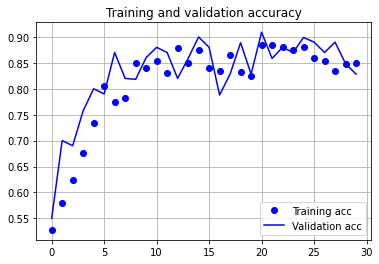

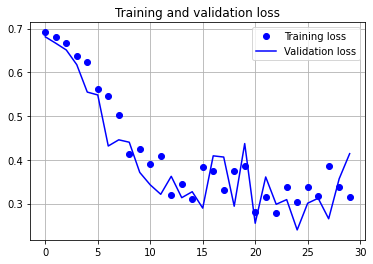

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

# Test on test set

In [ ]:
from keras_video import VideoFrameGenerator

classes = ['target' , 'others']
# some global params
SIZE = (112, 112)
CHANNELS = 3
NFRAME = 15
BS = 10
# pattern to get videos and classes
glob_pattern='/content/drive/MyDrive/kinetics/test/{classname}/*.mp4'

# Create video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 189 files for train


In [ ]:
model.evaluate(test)

18/18 [==============================] - 4s 159ms/step - loss: 0.3291 - accuracy: 0.8889


[0.3290700614452362, 0.8888888955116272]